# TP4 : Intégration numérique

Dans ce TP, on étudiera comment mettre en œuvre des méthodes d'intégration numérique pratiques. On commencera par la formule de Newton-Cotes, qui utilise des nœuds uniformément espacés. On considèrera ensuite les polynômes de Legendre et la formule de quadrature de Gauss, qui est plus précise. Enfin, on examinera les formules de quadrature composées.

## Exercice 1 : La formule de Newton-Cotes

On rappelle que pour les nœuds $a\leq c_1<c_2<\ldots<c_s\leq b$, la formule de quadrature est donnée par
$$
    \int_a^b\! f(x)\, \mathrm{d}x \approx \sum_{i=1}^s f(c_i) w_i \;,
$$
où les poids $w_i$ et les polynômes de Lagrange $\ell_i$ sont donnés par
$$
    w_i = \int_{a}^b\! \ell_i(t)\,\mathrm{d}t,\qquad \ell_i(t) = \prod_{j=1,j\neq i}^s \frac{t-c_j}{c_i-c_j} \;.
$$
Ceci se déduit de l'approximation de l'intégrale $\int_a^b f(x)\,\mathrm{d}x$ en approximant d'abord $f$ par un polynôme $p(t)$ de degré $s-1$ en utilisant l'interpolation dans les noeuds $(c_1,\dots,c_s)$, puis en utilisant $\int_a^bf(x)\,\mathrm{d}x\approx\int_a^bp(x)\,\mathrm{d}x$.

In [12]:
import numpy as np

### Exercice 1a)
> Implémenter une fonction `quadrature_poids(a, b, c_liste)` qui prend en entrée le domaine d'intégration $[a, b]$ et les noeuds d'interpolation `c_liste = [c1, ..., cs]` et calcule les poids de quadrature $w_i$ définis ci-dessus.
>
> Vous devez d'abord implémenter la fonction `lagrange_poly(i, c_liste)` qui calcule les coefficients du polynôme de Lagrange $\ell_i$ définis ci-dessus.
----

Les fonctions suivantes peuvent vous être utiles :
- `np.prod(a)` donne le produit de toutes les entrées d'un array `a`. Par exemple, `np.prod([2, 3, 4])` donne `12`.  
- `np.poly(racines)` donne les coefficients d'un polynôme dont les racines sont données par `racines`. Par exemple, `np.poly([-1, 0, 1])` donne `[1, 0, -1, 0]` ce qui correspond au polynôme $x^3-x=(x+1)x(x-1)$.  
- `np.polyint(coeff)` donne les coefficients de l'intégrale $q(t) = \int_0^t\!p(x)\,\mathrm{d}x$ où les coefficients de $p(t)$ sont donnés par `coeff`.  
- `np.polyval(coeff, x)` évalue en `x` le polynôme dont les coefficients sont donnés par `coeff`. Ici, `x` peut être une valeur unique ou un array de valeurs.

In [13]:
import numpy as np

def lagrange_poly(i, c_liste):
    """
    Polynôme de Lagrange pour le i-ième point pour les noeuds `c_liste`.

    Renvoie le polynôme sous la forme d'un array numpy de coefficients.
    """
    # Si c_liste a une longueur de un, renvoier le polynôme constant 1
    if len(c_liste) == 1: return np.array([1.0])
    c_i = c_liste[i]
    roots = np.concatenate((c_liste[:i], c_liste[i + 1 :]))
    denom_coeff = np.prod(c_i - roots)
    return np.poly(roots) / denom_coeff


def quadrature_poids(a, b, c_liste):
    """
    Poids de Newton-Cotes pour les noeuds `c_liste` sur l'intervalle [a, b].

    Renvoie les poids de quadrature sous forme d'un array numpy.
    """
    # int(a,b, f(x)) = (b-a)*int(0, 1, f(a + (b-a)*t))
    s, h = len(c_liste), b-a
    if s==1: return np.array([1])
    cis = np.array([(cj-a)/h for cj in c_liste])
    
    w_i = lambda i: np.polyint(lagrange_poly(i, cis))
    #wis = np.array([w_i(i) for i in range(s)])
    pw = h #h if h in {0, 1} else h
    return pw * np.array([np.polyval(w_i(i), 1) for i in range(s)])
#np.polyval(wis , 1)

# multiply whole set by (b-a)**s and evaluate whole set in 1 bcs polynom linear Li(0) should be 0


On veut calculer $\{\ w_i(t)\ \}_{1\leq i \leq s}$ où
$$w_i \ =\  \int_{a}^{b}{l_i(t) dt}  \ =\ 
  (b-a)\cdot \int_0^1{\prod_{j=1 \neq i}^{s}{(b-a)(u - \frac{c_j - a}{b - a})} } \ = \
(b-a)^s \cdot (\ L_i(u) \Big|_0^1\ )$$

où 
$$ L_i = poly(\{\ \frac{cj-a}{b-a}\ \}_{1\leq j \neq i \leq s}) $$

Apparement multiplier les s $L_i$ par $(b-a)^s$ marche pas et faudrait seulement multiplier par $(b-a)$ pourquoi ? => Dans le chgmt de var on a clairement un facteur de (b-a) par terme qu'on peut yeet du produit pour les $s$ éléments.

=> Parce qu'on fait l'intégrale de $[0, t]$ et pas de $[0, 1]$ =>  $q(t) = \int^{t}_{0}{p(t)} dt$  et pas $q(t) = \int^{1}_{0}{p(t)} dt$. 
=> $\phi(u) = u-a$, => $f(\phi(a)) = 0,\quad f(\phi(b)) = f(b-a)$

et $\phi'(u) = u$ => $dt = du$

In [14]:
def test_lagrange_poly():
    assert np.allclose(
        lagrange_poly(0, np.array([0, 0.5, 1])), np.array([2, -3, 1])
    ), "La fonction lagrange_poly ne fonctionne pas correctement"
    assert np.allclose(
        lagrange_poly(1, np.array([0, 0.5, 1])), np.array([-4, 4, 0])
    ), "La fonction lagrange_poly ne fonctionne pas correctement"

    poly10 = lagrange_poly(4, np.linspace(-1, 1, 10))
    assert poly10.shape == (10,), "La polynôme n'a pas le bon degré"
    assert (
        np.abs(np.sum(poly10)) < 1e-14
    ), "La somme des coefficients doit être nulle pour un liste de noeuds symétriques"
    assert lagrange_poly(0, [1]) == np.array(
        [1]
    ), "Si c_liste est de longueur 1, la fonction doit retourner un polynôme constant"


test_lagrange_poly()


def test_quadrature_poids():
    from scipy.special import roots_legendre

    assert np.allclose(
        quadrature_poids(0, 1, np.array([0.5])), np.array([1])
    ), "newton_cotes_poids ne fonctionne pas pour les noeuds [0.5] (regle point milieu)"
    assert np.allclose(
        quadrature_poids(0, 1, np.array([0, 1])), np.array([0.5, 0.5])
    ), "newton_cotes_poids ne fonctionne pas pour les noeuds [0,1] (regle trapèze)"
    assert np.allclose(
        quadrature_poids(0, 1, np.array([0, 0.5, 1])),
        np.array([1 / 6, 2 / 3, 1 / 6]),
    ), "newton_cotes_poids ne fonctionne pas pour les noeuds [0,0.5,1] (regle de Simpson)"

    assert np.allclose(
        quadrature_poids(-3, 3, np.array([-1, 0, 1])), np.array([9, -12, 9])
    ), "newton_cotes_poids ne fonctionne pas pour les noeuds [-1,0,1]  sur [-3,3]"
    assert np.allclose(
        quadrature_poids(-12, 3, np.array([-10, -5, 0, 1])),
        np.array([4.52045455, 5.175, 1.725, 3.57954545]),
    ), "newton_cotes_poids ne fonctionne pas pour les noeuds [-10,-5,0,1]  sur [-12,3]"

    for i in [2.5, 10]:
        racines, poids = roots_legendre(10)
        assert np.allclose(
            quadrature_poids(-1, 1, racines), poids
        ), "newton_cotes_poids ne fonctionne pas pour les noeuds de Legendre"


test_quadrature_poids()


### Exercise 1b)
La manière la plus simple de choisir des nœuds est de considerer la partition uniforme $a\leq c_1<\cdots c_s\leq b$ où $c_1=a$, $c_s=b$ et $|c_i-c_{i+1}|=h$ pour tout $i$. 
(Si $s=1$ alors $c_1=(a+b)/2$ à la place). Cela conduit à la formule de la quadrature de Newton-Cotes.

---
> Implémentez la fonction `newton_cotes(f, a, b, s)` qui approxime $\int_a^b f(x)\,\mathrm{d}x$ en utilisant la formule de quadrature en `s` étages avec des noeuds uniformément espacés.
---

In [15]:
def newton_cotes(f, a, b, s):
    """
    Approxime l'integrale de `f` de `a` à `b` en utilisant la formule de
    quadrature en `s` étages avec des noeuds uniformément espacés.
    """
    # VOTRE CODE ICI
    # sum of the w_i * f(c_i)
    nodes = np.linspace(a, b, num=s) if s != 1 else (a+b)/2 # np.linspace ne fonctionne pas avec s=1 (il renvoie a, et non (a+b)/2)
    wis = quadrature_poids(a, b, nodes)
    return np.array([f(ci)* wi for ci, wi in zip(nodes, wis)]).sum()


In [16]:
def test_newton_cotes():
    assert (
        abs(newton_cotes(lambda x: x**2, 0, 1, 3) - 1 / 3) < 1e-12
    ), "La formule de Newton-Cotes de degré 3 ne fonctionne pas correctement pour f(x) = x**2"
    assert (
        abs(newton_cotes(lambda x: x**2, 0, 1, 2) - 1 / 2) < 1e-12
    ), "La formule de Newton-Cotes de degré 3 ne fonctionne pas correctement pour f(x) = x**2"
    assert (
        abs(newton_cotes(lambda x: x**3, 0, 1, 3) - 1 / 4) < 1e-12
    ), "La formule de Newton-Cotes de degré 3 ne fonctionne pas correctement pour f(x) = x**3"
    assert (
        abs(newton_cotes(lambda x: x**3, -2, 1, 3) + 3.75) < 1e-12
    ), "La formule de Newton-Cotes de degré 3 ne fonctionne pas correctement pour f(x) = x**3"

    assert (
        abs(newton_cotes(np.cos, -2, 1, 3) - 1.8172428584412441) < 1e-12
    ), "La formule de Newton-Cotes de degré 3 ne fonctionne pas correctement pour f(x) = cos(x)"



%timeit test_newton_cotes()


3.01 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Nous traçons ci-dessous l'erreur absolue de la formule de Newton-Cotes pour $f(x)=\sin(x)$ sur $[0, 4]$ et $f(x) = 1/(1+x^2)$ sur $[-5, 5]$.

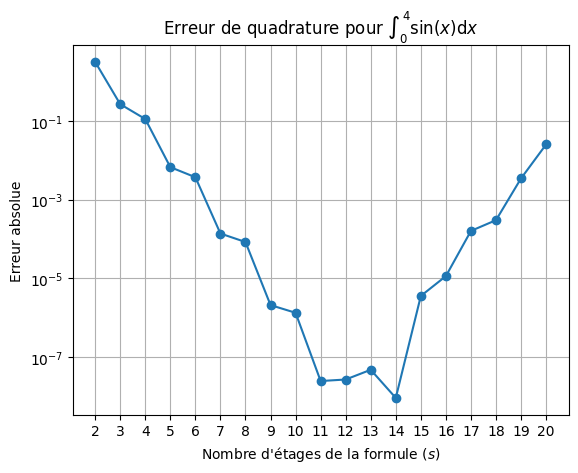

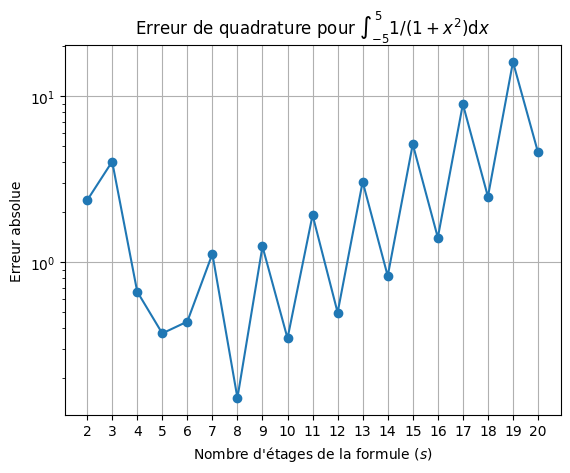

In [17]:
import matplotlib.pyplot as plt


def plot_newton_cotes(f, f_int_vrais, a, b, s_list, title=None):
    errors = []
    for s in s_list:
        approx = newton_cotes(f, a, b, s)
        errors.append(np.abs(f_int_vrais - approx))
    plt.plot(s_list, errors, "-o")
    plt.xlabel("Nombre d'étages de la formule ($s$)")
    plt.ylabel("Erreur absolue")
    plt.yscale("log")
    plt.grid()
    plt.xticks(s_list)
    plt.title(title)
    plt.show()


plot_newton_cotes(
    np.sin,
    1 - np.cos(4),
    0,
    4,
    np.arange(2, 21),
    title=r"Erreur de quadrature pour $\int_0^4 \sin(x) \mathrm{d}x$",
)


def fonction_runge(x):
    return 1 / (1 + x**2)


plot_newton_cotes(
    fonction_runge,
    2 * np.arctan(5),
    -5,
    5,
    np.arange(2, 21),
    title=r"Erreur de quadrature pour $\int_{-5}^51/(1+x^2) \mathrm{d}x$",
)


> **Réflexion** : Vous devriez observer que pour $\sin(x)$, l'erreur absolue diminue avec l'ordre d'intégration jusqu'à environ $s=14$, puis recommence à augmenter rapidement. Pourquoi cela se produit-il ?


> **Réflexion** : La formule de Newton-Cotes donne des résultats très imprécis pour la fonction de Runge $f(x)=1/(1+x^2)$. Pourquoi cela se produit-il ?
 

#### 1. Pourquoi l'erreur re-augmente pour s>=14 ?
Aucune idée, peut-être à cause du dégré de precision max, le $\varepsilon_{mach}$ mais l'erreur ré-augmente trop, trop vite sans se stabiliser pour que ce soit ça (peut-être). 

#### 2. Pourquoi approx mauvaise pour Runge ?
Parce que les points équidistant sont vraiment très loin d'être optimisés pour l'interpolation polynomiale classique, et l'on avait vue que l'erreur d'intégration numérique dépendait / était liée fortement à celle de l'interpolation => on observe donc les mêmes "Pitfalls"

## Exercice 2: Polynômes de Legendre et formules de quadrature de Gauss

On rappelle que les polynômes de Legendre $P_k$ pour $k\geq 1$ forment un système orthogonal de polynômes sur l'intervalle $[-1,1]$ par rapport au produit scalaire
$$
    \langle f,\,g\rangle := \int_{-1}^1\!f(\tau)\cdot g(\tau)\,\mathrm{d}\tau \;.
$$
On normalise les polynômes de telle sorte que $P_k(1)=1$. En utilisant le théorème 4.10, on peut calculer les polynômes de Legendre en utilisant les relations de récurrence suivantes :
$$
    P_0(\tau) = 1,\quad P_1(\tau)=\tau,
$$
$$
    (k+1)P_{k+1}(\tau)=(2k+1)\tau P_k(\tau)-k P_{k-1}(\tau) \;.
$$

In [10]:
import numpy as np
from numpy import float64, ndarray, poly1d
from scipy.special import legendre
from typing import Any


### Exercice 2a)
> Implémentez la fonction `legendre_coeff(k)` qui retourne les coefficients des `k` premiers polynômes de Legendre $(P_0,\dots,P_{k-1})$ sous forme de matrice $k\times k$. Utilisez la relation de récurrence ci-dessus. La $i$-ième ligne correspond à $P_{i}$ et la $j$-ième colonne correspond au coefficient de $x^{k-j-1}$.
---
Vous pouvez utiliser `np.polymul` pour calculer le produit de deux polynômes à partir de leurs coefficients, et `np.polyadd` pour ajouter deux polynômes. Notez également que vous pouvez multiplier des polynômes par un scalaire en manipulant directement les coefficients.

On a donc: $P_0(x) = 1,\quad P_1(x) = x\quad $ et:  
$$
P_{k}(x) = \frac{2k-1}{k}P_{k-1}(x)\cdot x - \frac{k-1}{k}P_{k-2}(x)  \ \Leftrightarrow \ P_{k+1}(x) = \frac{(2k+1)\ P_k(x) \cdot x\ -\ k\  P_{k-1}(x) }{k+1}

$$

In [29]:
def p(p1, p2) -> ndarray|poly1d:
    """ Shorthand for np.polymul(p1, p2) """
    return np.polymul(p1, p2)
def ar(array): return np.array(array)

def legendre_coeff(k:int) -> ndarray[float64, Any]:
    """
    Renvoie une matrice contenant les coefficients des k premiers polynômes de
    Legendre.
    """
    if k < 1: raise ValueError("k must be >= 1")
    M = np.zeros((k, k), dtype=float64)
    def P(k): return M[k]
    M[0, -1] = 1
    if k == 1: return M
    np.ndarray
    M[1, -2] = 1
    if k == 2: return M
    
    
    (x := np.zeros(k))[-2] = 1
    for i in range(2, k):
        # x === np.array([1, 0])

        lhs, rhs = (2*i-1)/i * (P(i-1) * x), (i-1)/i * P(i-2)
        #! apparently lhs is (3, 1) and rhs (6, 1)
        #tmp = ( (2*i-1)/i * p(P(i-1), x) ) - ( (i-1)/i * P(i-2) )
        tmp = lhs - rhs
        
        M[i] = tmp
        if False: print("lu")
    return M

k = 6
coeff_mat = legendre_coeff(k)
assert coeff_mat.shape == (k, k), "legendre_coeff ne retourne pas une matrice de la bonne taille"
for j in range(k):
    leg = np.array(legendre(j))
    item = coeff_mat[j, -j-1 :]
    supp = lambda j: coeff_mat[j, -j-1:]
    
    if False: print("lul")
    assert np.allclose(leg, supp(j)),                   \
    f"legendre_coeff ne fonctionne pas pour k = {k}"



AssertionError: legendre_coeff ne fonctionne pas pour k = 6

In [40]:
def test_legendre_coeff_k(k):
    from scipy.special import legendre

    coeff_mat = legendre_coeff(k)
    assert coeff_mat.shape == (
        k,
        k,
    ), "legendre_coeff ne retourne pas une matrice de la bonne taille"
    for j in range(k):
        leg = np.array(legendre(j))
        item = coeff_mat[j, -j-1 :]
        supp = lambda j: coeff_mat[j, -j-1:]
        
        if False: print("lul")
        assert np.allclose(leg, supp(j)),                   \
        f"legendre_coeff ne fonctionne pas pour k = {k}"


#test_legendre_coeff_k(6)



In [ ]:
def test_legendre_coeff():
    from scipy.special import legendre

    for k in range(1, 10):
        coeff_mat = legendre_coeff(k)
        assert coeff_mat.shape == (
            k,
            k,
        ), "legendre_coeff ne retourne pas une matrice de la bonne taille"
        for j in range(k):
            leg = np.array(legendre(j))
            assert np.allclose(
                leg, coeff_mat[j, -j - 1 :]
            ), f"legendre_coeff ne fonctionne pas pour k = {k}"


test_legendre_coeff()


### Exercise 2b)

Au lieu d'utiliser des nœuds uniformément espacés dans la formule de quadrature, on peut utiliser les nœuds donnés par les racines des polynômes de Legendre. C'est-à-dire qu'on a $-1< c_1< \cdots< c_s < 1$ avec $P_s(c_k) = 0$.

---
> Implémenter la fonction `legendre_poids(s)` qui renvoie les racines de $P_s$ et les poids de quadrature correspondant à ces racines.
---



In [ ]:
def legendre_poids(s):
    """Calcule les racines de polynôme de Legendre et les poids de quadrature de
    Gauss-Legendre pour s étages.

    Renvoie un tuple `(racines, poids)` où `racines` et `poids` sont des numpy
    arrays avec taille `s`."""

    # VOTRE CODE ICI


In [ ]:
def test_legendre_poids():
    from scipy.special import roots_legendre

    for k in [2, 5, 10]:
        racines1, poids1 = legendre_poids(k)
        racines2, poids2 = roots_legendre(k)
        assert len(racines1) == len(
            racines2
        ), "legendre_poids ne retourne pas le bon nombre de racines"
        assert len(poids1) == len(
            poids2
        ), "legendre_poids ne retourne pas le bon nombre de poids"
        assert np.allclose(
            np.argsort(racines1), np.arange(k)
        ), "legendre_poids ne retourne pas les racines dans le bon ordre"
        assert np.allclose(
            racines1, racines2
        ), "legendre_poids ne retourne pas les bonnes racines"
        assert np.allclose(
            poids1, poids2
        ), "legendre_poids ne retourne pas les bons poids"


test_legendre_poids()


### Exercise 2c)
> Implémentez la fonction `quadrature_gauss(f, a, b, s)` qui approxime l'intégrale $\int_{a}^bf(x)\,\mathrm{d}x$ en utilisant la règle de quadrature de Gauss d'ordre $s$ (c'est-à-dire en utilisant les noeuds et les poids que vous venez de calculer en 2b)).
---

Si vous n'avez pas réussi à résoudre 2a) et 2b), alors vous pouvez utiliser `racines, poids = scipy.special.roots_legendre(s)` au lieu d'utiliser la fonction `legendre_poids`.

In [ ]:
from scipy.special import roots_legendre


def quadrature_gauss(f, a, b, s):
    """
    Approximer l'intégrale de f de a à b par la formule de Gauss en s étages.
    """
    # VOTRE CODE ICI


In [ ]:
def test_qaudrature_gauss():
    assert (
        abs(quadrature_gauss(lambda x: x**2, 0, 1, 3) - 1 / 3) < 1e-12
    ), "La formule de Gauss à 3 étages ne fonctionne pas correctement pour f(x) = x**2"
    assert (
        abs(quadrature_gauss(lambda x: x**2, 0, 1, 2) - 1 / 3) < 1e-12
    ), "La formule de Gauss à 2 étages ne fonctionne pas correctement pour f(x) = x**2"
    assert (
        abs(quadrature_gauss(lambda x: x**3, 0, 1, 3) - 1 / 4) < 1e-12
    ), "La formule de Gauss à 3 étages ne fonctionne pas correctement pour f(x) = x**3"
    assert (
        abs(quadrature_gauss(lambda x: x**3, -2, 1, 3) + 3.75) < 1e-12
    ), "La formule de Gauss à 3 étages ne fonctionne pas correctement pour f(x) = x**3"

    assert (
        abs(quadrature_gauss(np.cos, -2, 1, 3) - 1.751656940673832) < 1e-12
    ), "La formule de Gauss à 3 étages ne fonctionne pas correctement pour f(x) = cos(x)"


test_qaudrature_gauss()


On trace ci-dessous l'erreur absolue de la formule de quadrature de Gauss pour les mêmes fonctions que précédemment.

In [ ]:
def plot_quadrature_gauss(f, f_int_true, a, b, s_list, title=None):
    errors = []
    for s in s_list:
        approx = quadrature_gauss(f, a, b, s)
        errors.append(np.abs(f_int_true - approx))
    plt.plot(s_list, errors, "-o")
    plt.xlabel("Nombre d'étages de la formule ($s$)")
    plt.ylabel("Erreur absolue")
    plt.yscale("log")
    plt.grid()
    plt.xticks(s_list)
    plt.title(title)
    plt.show()


plot_quadrature_gauss(
    np.sin,
    1 - np.cos(4),
    0,
    4,
    np.arange(2, 21),
    title=r"Erreur de quadrature pour $\int_0^4 \sin(x) \mathrm{d}x$",
)

true_integral = 2 * np.arctan(5)


def fonction_runge(x):
    return 1 / (1 + x**2)


plot_quadrature_gauss(
    fonction_runge,
    true_integral,
    -5,
    5,
    np.arange(2, 21),
    title=r"Erreur de quadrature pour $\int_{-5}^51/(1+x^2) \mathrm{d}x$",
)


> **Réflexion** : L'erreur de la formule de quadrature de Gauss est-elle meilleure ou pire que celle de Newton-Cotes ? Pourquoi ?

> **Réflexion** : Comparez le tracé ci-dessus en utilisant `scipy.special.roots_legendre` et `legendre_poids`. Vous pouvez constater qu'en utilisant la fonction `scipy`, nous obtenons de bien meilleurs résultats pour les degrés supérieurs. Comment cela se fait-il ?


## Exercise 3: Formules de quadrature composées

Un moyen simple d'améliorer la précision d'une méthode de quadrature consiste à diviser d'abord le domaine d'intégration en sous-intervalles. Autrement dit, on subdivise $[a,b] = [c_0,c_1]\sqcup[c_1,c_2]\sqcup [c_{N-1},c_N]$, et on calcule
$$
    \int_{a}^b f(x)\,\mathrm dx = \sum_{i=1}^N \int_{c_{i-1}}^{c_i}f(x)\mathrm dx \;.
$$
Chaque intégrale de la somme est ensuite approchée par quadrature. Ceci est particulièrement utile pour intégrer des fonctions difficiles à interpoler à l'aide de polynômes, comme la fonction de Runge. 

---
> Implémenter la fonction `quadrature_composee(f, a, b, s, N)` qui approxime $\int_{a}^bf(x)\,\mathrm{d}x$ en appliquant la formule de qaudrature de Gauss avec $s$ étages avec $N$ sous-intervalles uniformément espacés. 
---

Plutôt que d'utiliser la fonction `quadrature_gauss(f, a, b, s)` de l'exercice 2c), vous pouvez utiliser la fonction `scipy` `scipy.integrate.fixed_quad` qui fait la même chose, mais qui peut être plus précise. Vous pouvez utiliser cette fonction comme suit :
```
    val, _ = fixed_quad(f, a, b, n=s)
```

In [ ]:
from scipy.integrate import fixed_quad

def quadrature_composee(f, a, b, s, N):
    """
    Approximer l'intégrale de `f` de `a` à `b` en utilisant une subdivision
    uniforme.

    L'intervalle d'intégration est divisé en N sous-intervalles de même
    longueur. L'intégrale sur chaque sous-intervalle est approximée en utilisant
    la formule de quadrature de Gauss.
    """
    # VOTRE CODE ICI


Vous pouvez utiliser les graphiques ci-dessous pour vérifier que votre implémentation fonctionne correctement. Ce graphique représente l'erreur absolue pour les mêmes fonctions que ci-dessous. Pour comparer correctement les formules composées avec différentes valeurs de $s$, nous utilisons le nombre d'évaluations de la fonction sur l'axe $x$ plutôt que le nombre $N$ de subdivisions.

In [ ]:
def plot_quadrature_composee(f, f_int_true, a, b, N_list, s_list, title=None):
    for s in s_list:
        errors = []
        for N in N_list:
            approx = quadrature_composee(f, a, b, s, N)
            errors.append(np.max([np.abs(f_int_true - approx), 1e-16]))
        plt.plot(N_list * s, errors, "-o", label=f"{s}")
    plt.xlabel("Nombre de evaluations de $f$")
    plt.ylabel("Erreur absolue")
    plt.loglog()
    plt.grid()
    plt.title(title)
    plt.legend(title="Nombre d'étages ($s$)")
    plt.show()


odres = [2, 3, 5, 9, 15]
plot_quadrature_composee(
    np.sin,
    1 - np.cos(4),
    0,
    4,
    np.arange(2, 21),
    odres,
    title=r"Erreur de quadrature pour $\int_0^4 \sin(x) \mathrm{d}x$",
)

plot_quadrature_composee(
    fonction_runge,
    true_integral,
    -5,
    5,
    np.arange(2, 21),
    odres,
    title=r"Erreur de quadrature pour $\int_{-5}^51/(1+x^2) \mathrm{d}x$",
)


> **Réflexion:** Est-il toujours avantageux d'utiliser un plus grand nombre d'étapes pour la quadrature ? 
